In [29]:
import queue
import sys
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
import numpy as np
import sounddevice as sd
from numpy.fft import fft, fftfreq
from scipy.signal import find_peaks, periodogram

# Part 1: Obtaining Audio

First we specify all relevant information.

In [71]:
device = 0 # id of the audio device by default
window = 2 # number of seconds to record
freq_max = 1000 #maximum frequency to show on spectrum

Obtain an audio sample with length of time given by `window` above

In [88]:
q = queue.Queue()
device_info =  sd.query_devices(device, 'input')
samplerate = device_info['default_samplerate']
length  = int(window*samplerate)
X = sd.rec(length, channels=1, dtype=np.float64)[:,0]

Compute the power spectrum of the audio sample

In [89]:
freq, power_spectrum = periodogram(X, samplerate)

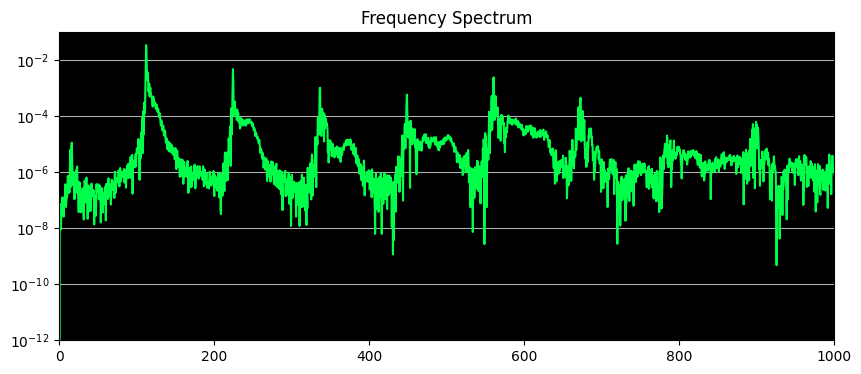

In [97]:
fig, ax = plt.subplots(figsize=(10,4))
ax.set_title("Frequency Spectrum")
lines = ax.plot(freq, power_spectrum, color = (0,1,0.29))
ax.set_facecolor((0,0,0))
ax.set_yticks([0])
ax.yaxis.grid(True)
ax.semilogy()
ax.set_ylim(1e-12,1e-1)
ax.set_xlim(0,1000)
plt.show()

We can find the "peaks" of the power spectrum using scipy's `find_peaks` function. We need to specify

* required height of the peaks
* minimum distance between the peaks
* prominence of the peaks

We'll take the logarithm of the peaks and look for peaks with magnitude greater than $10^{-4}$

In [107]:
df = np.diff(freq)[0]
N = int(freq_max/df)
peaks = find_peaks(np.log10(power_spectrum[0:N]), height=-6, distance=100, prominence=1)[0]
freq_peaks = freq[peaks]

(90.0, 130.0)

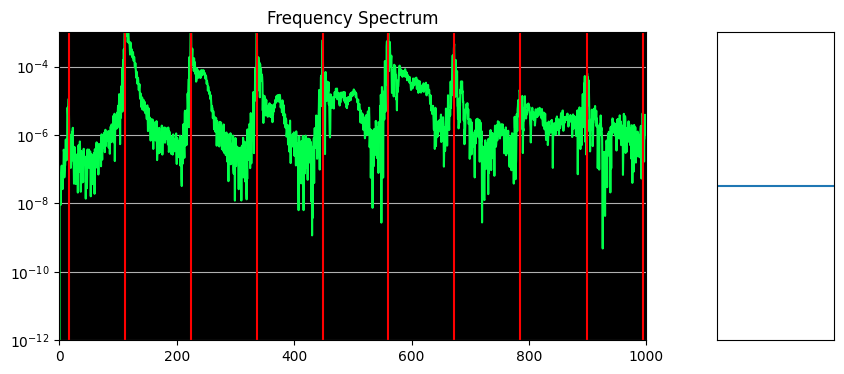

In [108]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), width_ratios=[1,0.2])
ax = axes[0]
ax.set_title("Frequency Spectrum")
lines = ax.plot(freq, power_spectrum, color = (0,1,0.29))
[ax.axvline(peak, color='r') for peak in freq_peaks]
ax.set_facecolor((0,0,0))
ax.set_yticks([0])
ax.yaxis.grid(True)
ax.semilogy()
ax.set_ylim(1e-12,1e-3)
ax.set_xlim(0,1000)
ax = axes[1]
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.axhline(110)
line_tone = LineCollection([], color='r')
ax.add_collection(line_tone)
ax.set_ylim(90,130)

Next we want to check which note the frequency spectrum is closest to. We use the following

$$\sum_i \left(\frac{p_i/F_j- \text{round}(p_i/F_j)}{(p_i/F_j)} <0.02\right)$$

to count the number of peaks within $p_i$ within the note $F_j$ (here $F_j$ is the fundamental frequency, but this counts peaks that are close to the upper harmonics). We choose a given note if the number of peaks satisfying this condition lies above `total_peaks_required`

In [109]:
def check_freq(freq_peaks, note_frequency, total_peaks_required=4):
    total_peaks = np.sum(np.abs((freq_peaks/note_frequency - np.round(freq_peaks/note_frequency))/(freq_peaks/note_frequency))<0.02)
    if total_peaks>total_peaks_required:
        return True
    else:
        return False

We see if the spectrum above corresponds to an A note:

In [113]:
check_freq(freq_peaks, 110, total_peaks_required=4)

True

We can do this for all guitar notes:

In [118]:
guitar_notes = [82.41, 110, 146.83, 196, 246.94, 329.63]
possible_notes = [check_freq(freq_peaks, note, total_peaks_required=4) for note in guitar_notes]
possible_notes

[False, True, False, False, False, False]

We can use that list to get our note:

In [122]:
note = guitar_notes[np.argmax(possible_notes)]
note

110

Now we can use this to get the % accuracy of the note, and add this to the right of the figure

(90.0, 110.0)

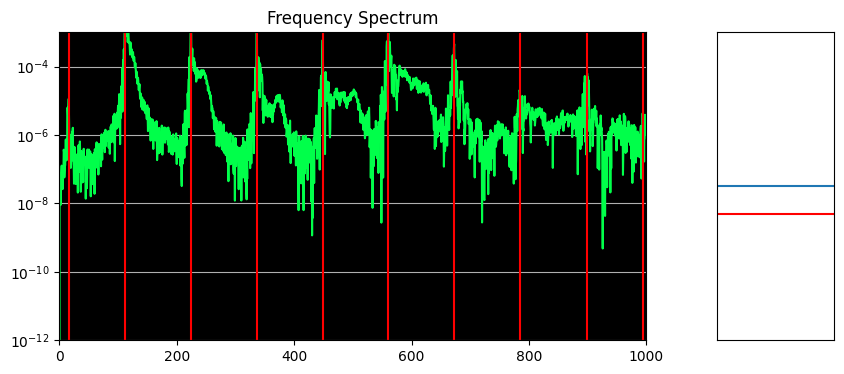

In [126]:
fig, axes = plt.subplots(1, 2, figsize=(10,4), width_ratios=[1,0.2])
ax = axes[0]
ax.set_title("Frequency Spectrum")
lines = ax.plot(freq, power_spectrum, color = (0,1,0.29))
[ax.axvline(peak, color='r') for peak in freq_peaks]
ax.set_facecolor((0,0,0))
ax.set_yticks([0])
ax.yaxis.grid(True)
ax.semilogy()
ax.set_ylim(1e-12,1e-3)
ax.set_xlim(0,1000)
ax = axes[1]
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
ax.axhline(100)
[ax.axhline(note/f * 100, color='r') for f in freq_peaks]
ax.set_ylim(90,110)

As can be seen, I was slightly flat. The red line on the right hand side can be updated during animation as one tunes their guitar.